#**1. Importing Data**

We will use VIX data and S&P 500 data from 2014-05-01 to 2024-04-30 to train the model and from 2023-01-01 to 2024-07-31 to test the model

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2014-05-01  13.64  13.75  13.10  13.25      13.25       0
2014-05-02  13.15  13.50  12.83  12.91      12.91       0
2014-05-05  13.95  14.20  13.08  13.29      13.29       0
2014-05-06  13.65  13.90  13.28  13.80      13.80       0
2014-05-07  13.64  14.49  13.39  13.40      13.40       0
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-05-01  1884.390015  1888.589966  1878.040039  1883.680054  1883.680054   
2014-05-02  1885.300049  1891.329956  1878.500000  1881.140015  1881.140015   
2014-05-05  1879.449951  1885.510010  1866.770020  1884.660034  1884.660034   
2014-05-06  1883.689941  1883.689941  1867.719971  1867.719971  1867.719971   
2014-05-07  1868.530029  1878.829956  1859.790039  1878.209961  1878.209961   

                Volume  
Date           

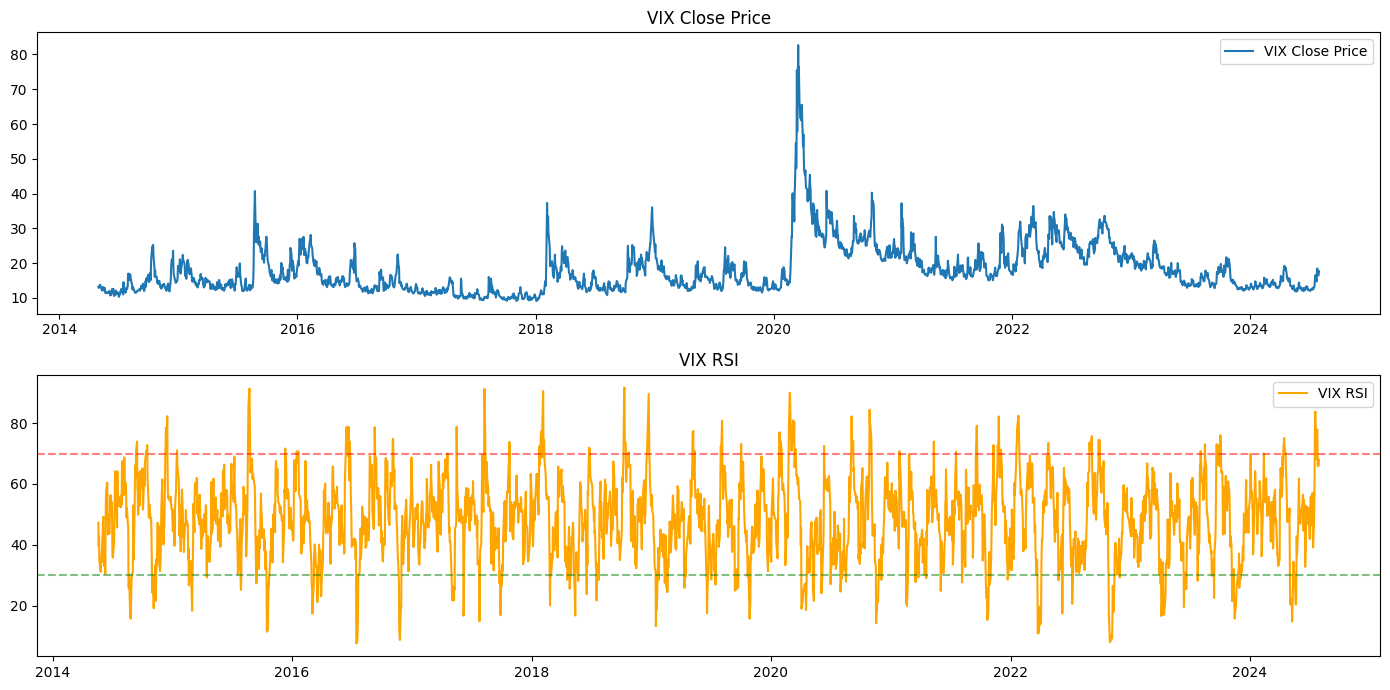

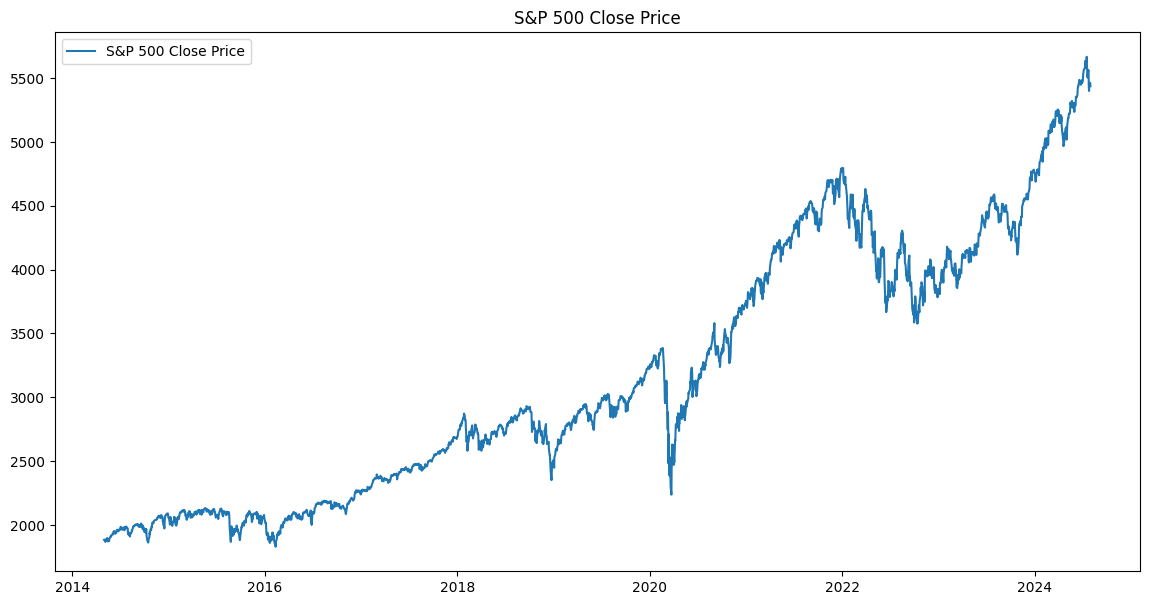

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from statsmodels.tsa.api import VAR
import numpy as np

# Define the tickers and the time period
vix_ticker = "^VIX"
sp500_ticker = "^GSPC"
start_date = "2014-05-01"
end_date = "2024-07-31"

# Fetch the VIX data
vix_data = yf.download(vix_ticker, start=start_date, end=end_date)

# Fetch the S&P 500 data
sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date)

# Display the first few rows of the VIX data
print(vix_data.head())

# Display the first few rows of the S&P 500 data
print(sp500_data.head())


# Calculate RSI for VIX
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Parameters
rsi_period = 14  # Common period for RSI

# Calculate RSI for VIX
vix_data['RSI'] = calculate_rsi(vix_data, rsi_period)

# Plot VIX data with RSI
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(vix_data['Close'], label='VIX Close Price')
plt.title('VIX Close Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(vix_data['RSI'], label='VIX RSI', color='orange')
plt.axhline(70, color='red', linestyle='--', alpha=0.5)
plt.axhline(30, color='green', linestyle='--', alpha=0.5)
plt.title('VIX RSI')
plt.legend()

plt.tight_layout()
plt.show()

# Plot S&P 500 data
plt.figure(figsize=(14, 7))
plt.plot(sp500_data['Close'], label='S&P 500 Close Price')
plt.title('S&P 500 Close Price')
plt.legend()
plt.show()


#**2. Exploratory Data Analysis**

We study the behavior of S&P 500 Returns, VIX RSI and VIX returns and how they correlate with each other

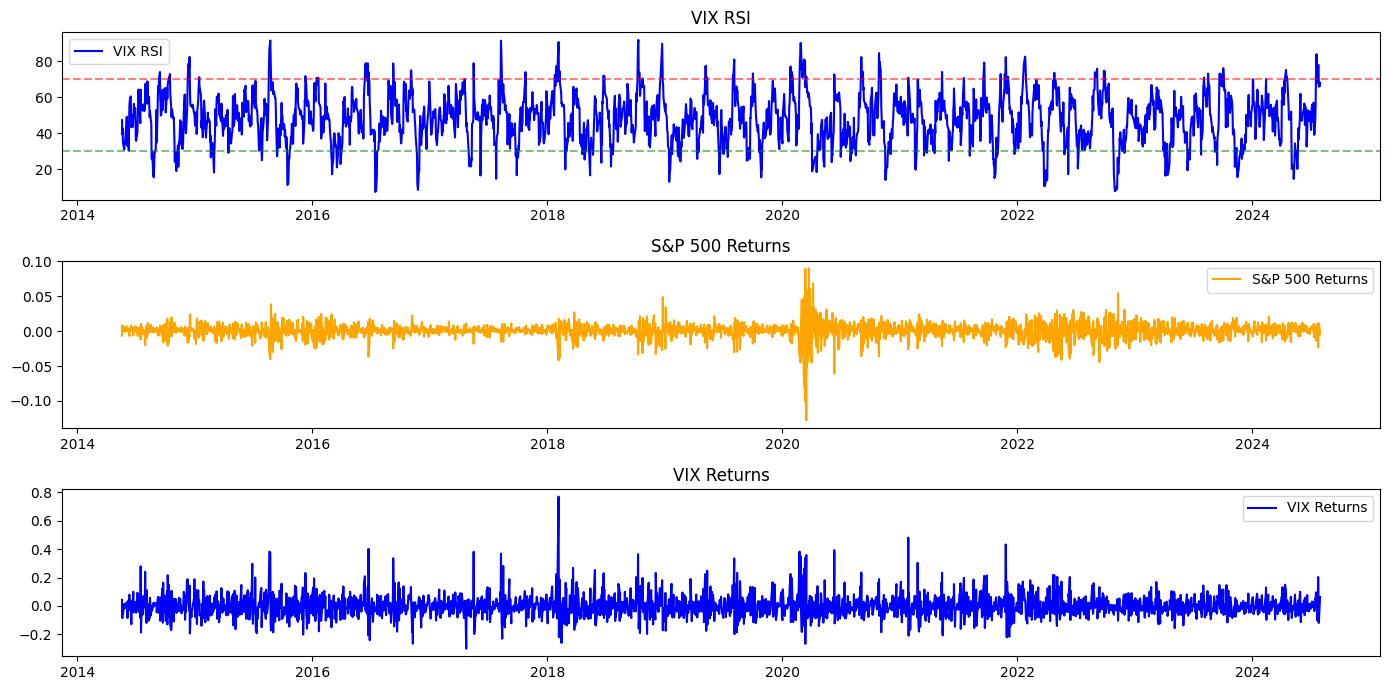

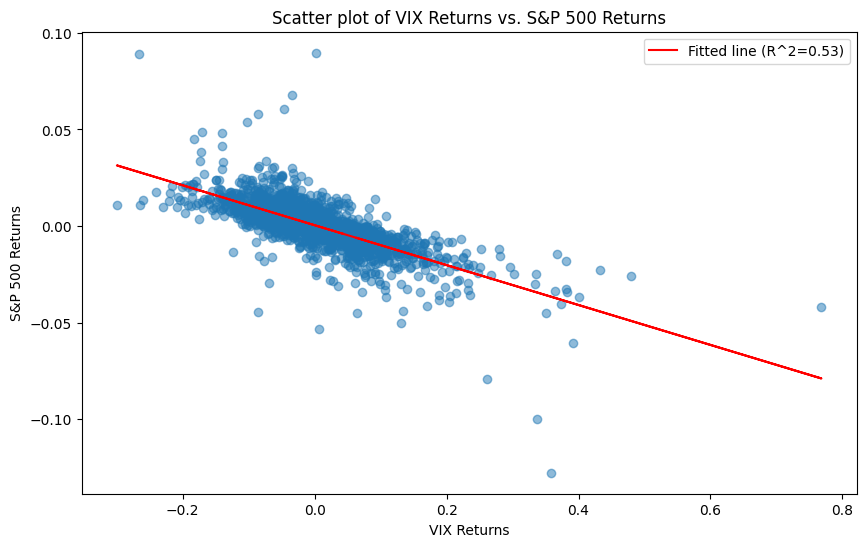

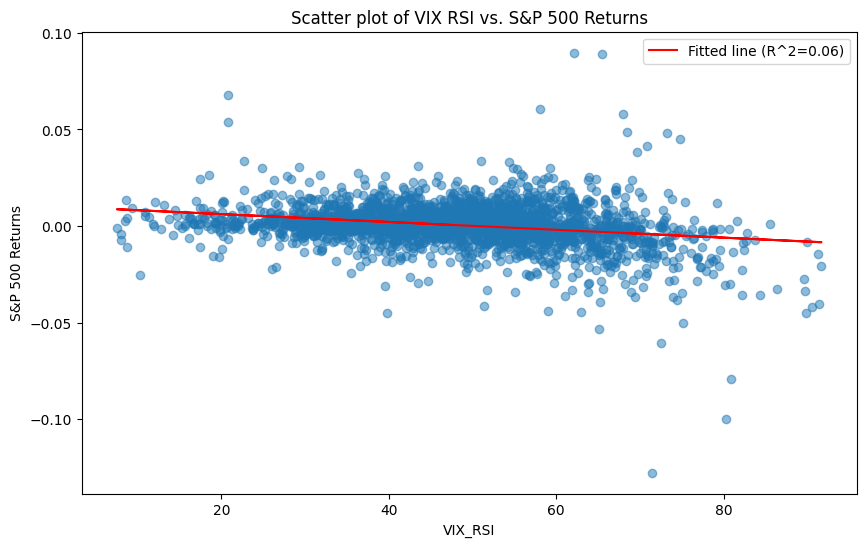

               SP500_Returns   VIX_RSI  VIX_Returns
SP500_Returns       1.000000 -0.245854    -0.725473
VIX_RSI            -0.245854  1.000000     0.257240
VIX_Returns        -0.725473  0.257240     1.000000


In [6]:
# Calculate VIX returns
vix_data['Returns'] = np.log(vix_data['Close'] / vix_data['Close'].shift(1))

# Calculate S&P 500 returns
sp500_data['Returns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))

# Merge VIX returns and S&P 500 returns data
merged_data = pd.merge(sp500_data['Returns'], vix_data['RSI'], left_index=True, right_index=True, how='inner')
merged_data = pd.merge(merged_data, vix_data['Returns'], left_index=True, right_index=True, how='inner')
merged_data.columns = ['SP500_Returns', 'VIX_RSI', 'VIX_Returns']
merged_data = merged_data.dropna()
merged_data[:len(merged_data)//50*50]

# Plot VIX returns, S&P 500 returns and VIX RSI
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(merged_data['VIX_RSI'], label='VIX RSI', color='blue')
plt.axhline(70, color='red', linestyle='--', alpha=0.5)
plt.axhline(30, color='green', linestyle='--', alpha=0.5)
plt.title('VIX RSI')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(merged_data['SP500_Returns'], label='S&P 500 Returns', color='orange')
plt.title('S&P 500 Returns')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(merged_data['VIX_Returns'], label='VIX Returns', color='blue')
plt.title('VIX Returns')
plt.legend()

plt.tight_layout()
plt.show()

# Scatter plot and linear regression of VIX returns vs. S&P 500 returns
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['VIX_Returns'], merged_data['SP500_Returns'], alpha=0.5)
slope, intercept, r_value, p_value, std_err = linregress(merged_data['VIX_Returns'], merged_data['SP500_Returns'])
plt.plot(merged_data['VIX_Returns'], intercept + slope * merged_data['VIX_Returns'], 'r', label=f'Fitted line (R^2={r_value**2:.2f})')
plt.xlabel('VIX Returns')
plt.ylabel('S&P 500 Returns')
plt.title('Scatter plot of VIX Returns vs. S&P 500 Returns')
plt.legend()
plt.show()

# Scatter plot and linear regression of VIX RSI vs. S&P 500 returns
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['VIX_RSI'], merged_data['SP500_Returns'], alpha=0.5)
slope, intercept, r_value, p_value, std_err = linregress(merged_data['VIX_RSI'], merged_data['SP500_Returns'])
plt.plot(merged_data['VIX_RSI'], intercept + slope * merged_data['VIX_RSI'], 'r', label=f'Fitted line (R^2={r_value**2:.2f})')
plt.xlabel('VIX_RSI')
plt.ylabel('S&P 500 Returns')
plt.title('Scatter plot of VIX RSI vs. S&P 500 Returns')
plt.legend()
plt.show()

# Calculate the correlation
correlation = merged_data.corr()
print(correlation)

#**3. Model Development**

We split the data into train and test set and fit a VAR model to predict S&P 500 returns for a 2-month period

In [7]:
# Split into training and test sets
train_start = '2014-05-01'
train_end = '2024-04-30'
train_end = '2023-01-01'
train_data = merged_data[train_start:train_end]
test_data = merged_data[train_end:]

# Fit the VAR model
model = VAR(train_data)
model_fitted = model.fit(maxlags=15)

# Forecasting
forecast_steps = len(test_data)
forecast = model_fitted.forecast(train_data.values[-model_fitted.k_ar:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=train_data.columns)
# Extract close prices for conversion
close_prices = sp500_data

# Compute the predicted prices from the log returns
predicted_log_returns = forecast_df['SP500_Returns']
predicted_prices = close_prices.iloc[-forecast_steps]['Close'] * np.exp(predicted_log_returns.cumsum())

# Prepare data for plotting
actual_prices = close_prices['2020-01-01':]['Close'].copy()
actual_prices.name = 'Actual'
predicted_prices_df = pd.Series(predicted_prices, index=test_data.index, name='Predicted')

# Combine for plotting
comparison_df = pd.concat([actual_prices, predicted_prices_df], axis=1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#**4. Model Evaluation**

We do a comparison of the actual vs predicted price of S&P 500 closing price to evaluate the effectiveness of the model

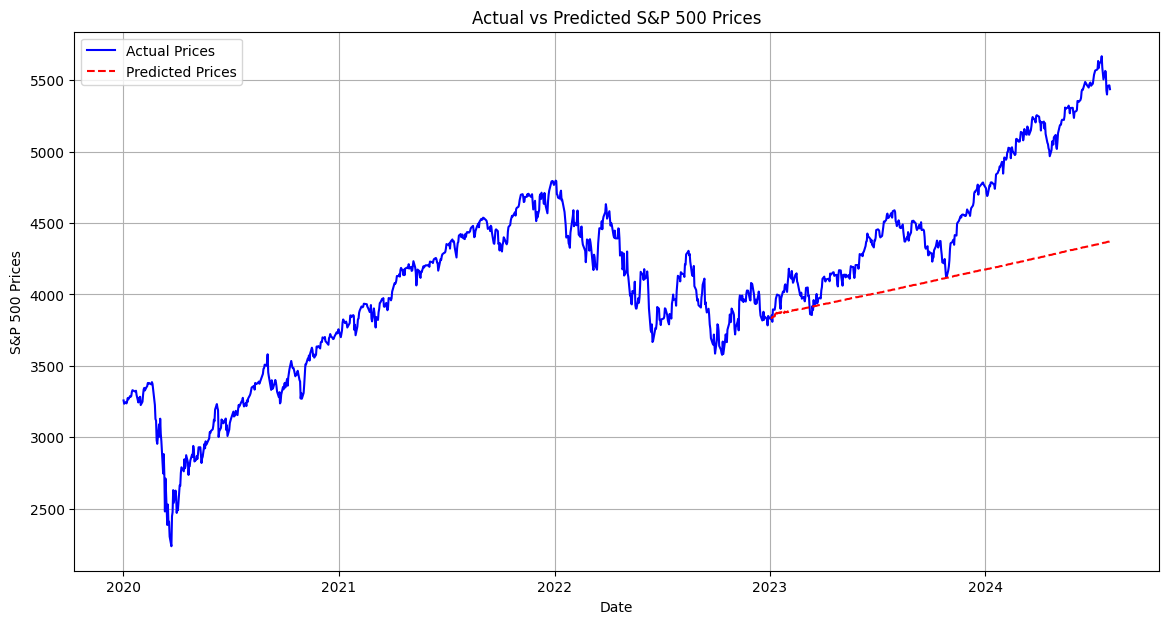

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual Prices', color='blue')
plt.plot(comparison_df.index, comparison_df['Predicted'], label='Predicted Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted S&P 500 Prices')
plt.xlabel('Date')
plt.ylabel('S&P 500 Prices')
plt.legend()
plt.grid(True)
plt.show()


#**5. Backtesting the RSI Strategy**

<ipython-input-9-853624e5483b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_data_filtered['RSI_Signal'] = vix_data_filtered['RSI'].apply(lambda x: 'Buy' if x < 30 else 'Sell')
<ipython-input-9-853624e5483b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vix_data_filtered['State'] = 'Changed'
<ipython-input-9-853624e5483b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

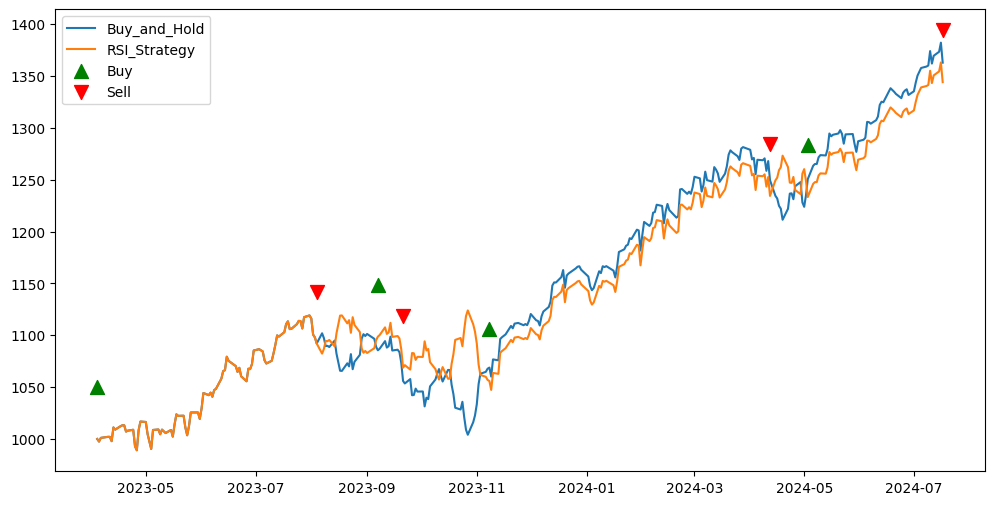

In [9]:
vix_data_filtered = vix_data[((vix_data['RSI'] < 30) | (vix_data['RSI'] > 70)) & (vix_data.index >= pd.to_datetime('2023-01-01'))]
vix_data_filtered['RSI_Signal'] = vix_data_filtered['RSI'].apply(lambda x: 'Buy' if x < 30 else 'Sell')
vix_data_filtered['State'] = 'Changed'

def check_change(vix):
  prev_action = vix['RSI_Signal'].shift(1)
  vix['State'] = vix['RSI_Signal'] != prev_action
  return vix

# Apply the function to the DataFrame
vix_data_filtered = check_change(vix_data_filtered)
vix_data_filtered = vix_data_filtered[vix_data_filtered['State']]
vix_data_filtered = vix_data_filtered[['RSI_Signal']]

# trading strategy: buy when RSI is below 30 and sell when RSI is above 70
trading_strategy = sp500_data.copy()['2023-04-04':'2024-07-17'][['Close']]
trading_strategy = trading_strategy.merge(vix_data_filtered['RSI_Signal'], left_index=True, right_index=True, how='left')
trading_strategy['RSI_Signal'].fillna(method='ffill', inplace=True)

# calculate returns for buy and sell based on RSI signal
trading_strategy['prev_action'] = trading_strategy['RSI_Signal'].shift(1)
trading_strategy.loc[trading_strategy['prev_action'] == 'Buy', 'Returns'] = np.log(trading_strategy['Close'] / trading_strategy['Close'].shift(1))
trading_strategy.loc[trading_strategy['prev_action'] == 'Sell', 'Returns'] = np.log(trading_strategy['Close'].shift(1) / trading_strategy['Close'])
trading_strategy['Returns'][0] = 0
trading_strategy['RSI_Strategy'] = 1000*np.exp(trading_strategy['Returns'].cumsum())

# calculate buy and hold equity value
sp500_buy_and_hold = sp500_data.copy()['2023-04-04':'2024-07-17']
sp500_buy_and_hold['Returns'] = np.log(sp500_buy_and_hold['Close'] / sp500_buy_and_hold['Close'].shift(1))
sp500_buy_and_hold['Buy_and_Hold'] = 1000*np.exp(sp500_buy_and_hold['2023-04-04':'2024-07-17']['Returns'].cumsum())
sp500_buy_and_hold['Buy_and_Hold'][0] = 1000

# combine the dfs
combined_df = pd.merge(sp500_buy_and_hold, trading_strategy['RSI_Strategy'], left_index=True, right_index=True, how='left')
combined_df = pd.merge(combined_df, vix_data_filtered, left_index=True, right_index=True, how='left')
combined_df = combined_df[['Buy_and_Hold', 'RSI_Strategy', 'RSI_Signal']]

# location of buy sell signal
combined_df.loc[combined_df['RSI_Signal'] == 'Buy', 'Buy'] = combined_df['RSI_Strategy'] + 50
combined_df.loc[combined_df['RSI_Signal'] == 'Sell', 'Sell'] = combined_df['RSI_Strategy'] + 50


# plot the equity of the 2 strategies
def plot_with_buy_sell_signals(combined_df, Buy_and_Hold, RSI_Strategy, RSI_Signal):
    plt.figure(figsize=(12, 6))
    plt.plot(combined_df.index, combined_df[Buy_and_Hold], label=Buy_and_Hold)
    plt.plot(combined_df.index, combined_df[RSI_Strategy], label=RSI_Strategy)

    # Plot buy signals
    buy_signals = combined_df[['Buy']]
    plt.scatter(buy_signals.index, buy_signals['Buy'], marker='^', color='green', label='Buy', s=100)

    # Plot sell signals
    sell_signals = combined_df[['Sell']]
    plt.scatter(sell_signals.index, sell_signals['Sell'], marker='v', color='red', label='Sell', s=100)

    plt.legend()
    plt.show()

plot_with_buy_sell_signals(combined_df, 'Buy_and_Hold', 'RSI_Strategy', 'RSI_Signal')

#**6. Results and Discussion**

From the graph above, we can see that the predicted price is moving in the same general direction of the actual price. The inference that can be made is that VIX RSI and VIX returns can be a good predictor of S&P 500 returns. Despite the fact that direction of the prediction is in accordance to the actual price, the gap between the predicted and actual price is still quite large. We believe that there are some more improvements that can be made to the model so that the predicted values are close to the actual values. The next step is to fine tune the model so that the predicted price moves closer towards the actual price. This may involve adding other valuable information and new predictors into the model so that the model can perform more accurately.